In [1]:
import os
import redshift_utils as rs
import pandas as pd
import time
import sagemaker
import boto3
from skrub import TableReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bucket = "edcs3.prod.biads"
boto_session = boto3.session.Session(region_name="eu-west-1")
sess = sagemaker.session.Session(boto_session, default_bucket=bucket)
region = sess.boto_session.region_name
account = sess.boto_session.client('sts').get_caller_identity()['Account']
role = sagemaker.get_execution_role()
ssm_client = boto3.client('ssm')
kms_key = ssm_client.get_parameter(Name='/prod/sagemaker/BIADS/sloth/KMS_KEY_ID', WithDecryption=True)["Parameter"]["Value"] 

In [3]:
def load_data(params, sql):
    sloth_credentials = rs.get_sloth_credentials()
    con = rs.connect_to_redshift(sloth_credentials)
    data = rs.execute_sql(
        RSconn=con,
        sql=sql,
        input_type="file",
        params=params
    )
    return data

In [13]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/same_team_multis.sql')
df = pd.DataFrame(data)


In [15]:
df = pd.read_csv('/home/sagemaker-user/sandbox/intro-project/data/same-team-multis.csv')

In [14]:
df.head(50)

,bet_year,brand,num_stm_bets,total_revenue,total_volume,margin,occurences_2,occurences_3,occurences_4,occurences_5_plus
0,2025,BF,190302,1396625.7469,3927701.0555,0.3555,176662,17422,4526,4278
1,2025,SBG,205619,148009.9447,298607.6778,0.4956,204329,1637,366,270
2,2025,PP,794899,3708614.2780,8478917.7755,0.4373,761173,56193,15478,10194


In [25]:
481268757.7617 - 1630551997.6527

-1149283239.891

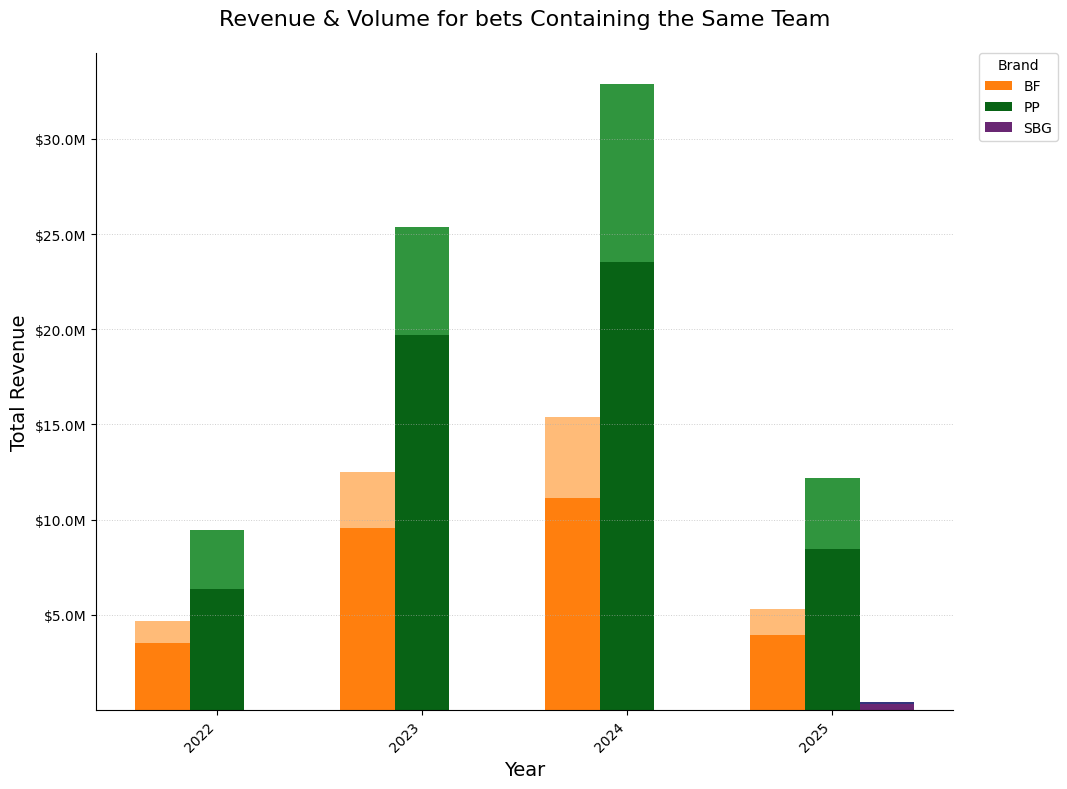

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

color_config = {
    'PP': {'main': '#086315', 'top': '#30953e'}, 
    'BF': {'main': '#ff7f0e', 'top': '#ffbb78'}, 
    'SBG': {'main': '#692773', 'top': '#33347c'}  # Green tones
}

plot_title="Revenue & Volume for bets Containing the Same Team"
# --- DATA PREPARATION ---
# Determine the order of years on the x-axis: ascending
year_col = 'bet_year'
sorted_years = sorted(df[year_col].unique())
df['total_margin'] = df['total_revenue'] - df['total_volume']

# --- PLOTTING SETUP ---
brands = sorted(df['brand'].unique())
num_years = len(sorted_years)
num_brands = len(brands)

x_indices = np.arange(num_years)  # The label locations for years
total_cluster_width = 0.8         # Total width for all bars in a cluster
bar_width = total_cluster_width / num_brands

# Dynamic figure width based on the number of years
fig, ax = plt.subplots(figsize=(max(12, num_years * 1.5), 8))

# --- CREATE BARS ---
# Create a bar cluster for each year
for i, brand_name in enumerate(brands):
    # Calculate the offset for each bar within a cluster
    offset = (i - (num_brands - 1) / 2) * bar_width

    # Get data for the current brand, ordered by sorted_years
    brand_data = df[df['brand'] == brand_name].set_index(year_col).reindex(sorted_years).fillna(0)

    revenues_for_brand = brand_data['total_revenue']
    costs_for_brand = brand_data['total_volume']
    margins_for_brand = brand_data['total_margin']

    # Plot total_volume (the 'main' part of the bar)
    ax.bar(x_indices + offset, costs_for_brand, bar_width,
           label=brand_name if i == 0 else "", # Only label the first set for a clean legend
           color=color_config.get(brand_name, {}).get('main', '#808080')) # Default grey if color not in config

    # Plot total_margin on top of total_volume
    ax.bar(x_indices + offset, revenues_for_brand, bar_width,
           bottom=costs_for_brand,
           color=color_config.get(brand_name, {}).get('top', '#A9A9A9')) # Default dark grey for top

# --- LABELS, TITLE, AND TICKS ---
ax.set_ylabel('Total Revenue', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(plot_title, fontsize=16, pad=20)
ax.set_xticks(x_indices)
ax.set_xticklabels(sorted_years, rotation=45, ha="right")

# --- FORMATTING ---
# Currency formatter for the y-axis
def currency_formatter_bmt(x, pos):
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'${x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

ax.yaxis.set_major_formatter(mticker.FuncFormatter(currency_formatter_bmt))

# --- LEGEND ---
# Manually create legend handles to show both colors for each brand
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_config[brand]['main'], edgecolor='none', label=brand) for brand in brands]
ax.legend(handles=legend_elements, title='Brand', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)


# --- STYLING AND LAYOUT ---
plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

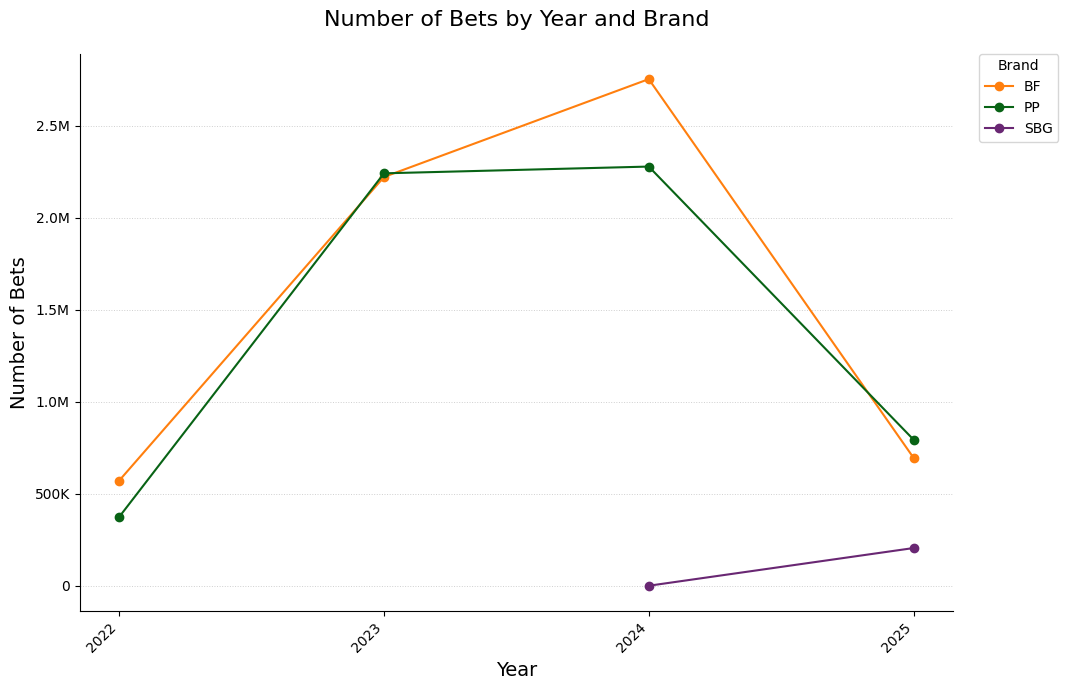

In [28]:
plot_title = "Number of Bets by Year and Brand"
year_col = 'bet_year'
bets_col = 'num_stm_bets'

# --- PLOTTING SETUP ---
fig, ax = plt.subplots(figsize=(12, 7))
brands = sorted(df['brand'].unique())

# --- CREATE LINES ---
# Create a line for each brand
for brand_name in brands:
    # Filter data for the current brand
    brand_data = df[df['brand'] == brand_name].sort_values(by=year_col)

    # Plot the line for the brand
    ax.plot(brand_data[year_col], brand_data[bets_col],
            label=brand_name,
            color=color_config.get(brand_name, {}).get('main', '#808080'), # Use main color
            marker='o', # Add markers to data points
            linestyle='-')

# --- LABELS, TITLE, AND TICKS ---
ax.set_ylabel('Number of Bets', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(plot_title, fontsize=16, pad=20)

# Ensure x-axis ticks are integers for years
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right")


# --- FORMATTING ---
# Formatter for the y-axis to make large numbers readable
def number_formatter_bmt(x, pos):
    if x >= 1_000_000:
        return f'{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'{x*1e-3:1.0f}K'
    return f'{x:1.0f}'

ax.yaxis.set_major_formatter(mticker.FuncFormatter(number_formatter_bmt))

# --- LEGEND ---
ax.legend(title='Brand', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

# --- STYLING AND LAYOUT ---
plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
